# Поиск калибровочных границ методами машинного обучения

Часто, когда мы моделируем какой-нибудь процесс и сравниваем реальные значения наблюдаемой характеристики с модельными, мы не знаем, какое отклонение реальности от модели является нормальным, а какое аномальным. Другими словами, мы не знаем, каковы те калибровочные границы, в пределах которых процесс протекает нормально.

В этой работе мы предлагаем такую идею: давайте засечем все абсолютные отклонения реальности от модели, упорядочим их по убыванию и посмотрим на то, как устроена эта кривая. Та точка, в которой будет наблюдаться локтевой сгиб, и будет граничной. Правда, для этого нужно уметь алгоритмически находить локтевые точки, но мы это умеем (см. одну из [предыдцщих работ](https://github.com/vladimir-mosin/fold-point)).

Полный текст этого исследования [доступен в формате pdf](paper.pdf). 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import sklearn.linear_model as skl
import matplotlib.pyplot as plt

import random

# Функция поиска локтевой точки
def fold_point(A, B):

    S_line = ((B - B.mean())**2).sum()

    R2_list = []

    shift = 3

    for i in np.arange(shift, len(A) - shift):

        X_left = A[:i].reshape(-1, 1)
        y_left = B[:i]

        model_left = skl.LinearRegression()
        model_left.fit(X_left, y_left)

        y_pred_left = model_left.predict(X_left)

        S_star_left = ((y_pred_left - y_left)**2).sum()

        X_right = A[i:].reshape(-1, 1)
        y_right = B[i:]

        model_right = skl.LinearRegression()
        model_right.fit(X_right, y_right)

        y_pred_right = model_right.predict(X_right)

        S_star_right = ((y_pred_right - y_right)**2).sum()

        S_star = S_star_left + S_star_right

        R2 = 1 - S_star/S_line

        R2_list.append(R2)
    
    fold_index = np.array(R2_list).argmax() + shift
    
    return fold_index

## Общий аглоритм генерации-детекции

Здесь мы генерируем 1000 значений в нормальным шумом. А части из них сознательно добавляем дополнительное отклонение о 0. Это те элементы, которые мы считаем объективно аномальными. Алгоритм детекции не знает, что это аномалии. Он определяет аномальные значения, исходя из своих соображений.

А потом мы смотрим, наколько хорошо он угадывает наши аномалии при помощи метрик бинакной классификации: acuracy, TP, TPR и т. д.

In [2]:
###### Константы

# Число образцов
N = 1000

# Параметры шума
noise_mean = 0
noise_std = 0.1


# Датафреймы для записи результатов по всем метрикам
df_out_pro = pd.DataFrame(index = np.arange(1, 100)
                         )
df_accuracy = pd.DataFrame(index = np.arange(1, 100)
                          )
df_TP = pd.DataFrame(index = np.arange(1, 100)
                    )
df_TN = pd.DataFrame(index = np.arange(1, 100)
                    )
df_FP = pd.DataFrame(index = np.arange(1, 100)
                    )
df_FN = pd.DataFrame(index = np.arange(1, 100)
                    )
df_TPR = pd.DataFrame(index = np.arange(1, 100)
                    )
df_FPR = pd.DataFrame(index = np.arange(1, 100)
                    )
# Варьируем выраженность аномалии
for out_coef in np.arange(1, 11):
    
    
    
    out_pro_list = []
    accuracy_list = []
    
    TP_list = []
    TN_list = []
    FP_list = []
    FN_list = []
    
    TPR_list = []
    FPR_list = []
    
    # Варьируем процент заложенных аномалий]
    for out_pro in np.arange(1, 100):

        y = np.random.normal(noise_mean, noise_std, N)

        out_shift = noise_std*out_coef
        out_num = random.sample(list(np.arange(N)), k=int((N/100)*out_pro))
        
        for i in out_num:
            y[i] = y[i] + out_shift
            
        fluctation = abs(y.mean() - y)
        
        # Индикатор изначально заложенной аномальности. Ести 1, то элемент выборки с таким номером является аномальным 
        cls = np.zeros(N)

        for i in out_num:
            cls[i] = 1
        
        df = pd.DataFrame()
        
        df['y'] = y       
        df['class'] = cls
        df['predict'] = y.mean()
        df['fluctation'] = fluctation

        df_sorted = df.sort_values(by = 'fluctation', ascending=False)
        
        # Ищем локтевую точку
        fold_num = fold_point(np.arange(N), df_sorted['fluctation'].to_numpy())
        bound = df_sorted['fluctation'].to_numpy()[fold_num]
        
        # Индикатор детектированной аномальности. Если 1, то детектирована аномалия
        df['hypothesis'] = np.zeros(N)
    
        df.loc[df['fluctation'] > bound, 'hypothesis'] = 1

        out_pro_list.append(100*fold_num/N)
        
        # Считаем все метрики        
        accuracy_list.append(100*len(df.loc[df['class'] == df['hypothesis']])/N)
        
        TP = len(df.loc[(df['hypothesis'] == 1) & (df['class'] == 1)])
        TN = len(df.loc[(df['hypothesis'] == 0) & (df['class'] == 0)])
        FP = len(df.loc[(df['hypothesis'] == 1) & (df['class'] == 0)])
        FN = len(df.loc[(df['hypothesis'] == 0) & (df['class'] == 1)])
        
        TP_list.append(TP)
        TN_list.append(TN)
        FP_list.append(FP)
        FN_list.append(FN)
        
        TPR_list.append(TP/(TP + FN))
        FPR_list.append(FP/(FP + TN))
    
    # Записываем метрики в датафреймы результатов
    df_out_pro[out_coef] = out_pro_list
    df_accuracy[out_coef] = accuracy_list
    
    df_TP[out_coef] = TP_list
    df_TN[out_coef] = TN_list
    df_FP[out_coef] = FP_list
    df_FN[out_coef] = FN_list
    
    df_TPR[out_coef] = TPR_list
    df_FPR[out_coef] = FPR_list

## Вывод результатов во внешние файлы

Все генерируется довольно-таки долго, надоедает ждать. Поэтому выводим все во внешние файлы. При необходиомсти ими можно будет воспользоваться без еще одного цикла генерации.

In [3]:
# df_out_pro.to_csv('data/df_out_pro.csv', index = False)
# df_accuracy.to_csv('data/df_accuracy.csv', index = False)
# df_TP.to_csv('data/df_TP.csv', index = False)
# df_TN.to_csv('data/df_TN.csv', index = False)
# df_FP.to_csv('data/df_FP.csv', index = False)
# df_FN.to_csv('data/df_FN.csv', index = False)
# df_TPR.to_csv('data/df_TPR.csv', index = False)
# df_FPR.to_csv('data/df_FPR.csv', index = False)

In [4]:
ddd = pd.read_csv('data/df_TPR.csv')
ddd

,1,2,3,4,5,6,7,8,9,10
0,0.300000,0.700000,0.900000,0.900000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
1,0.300000,0.700000,0.700000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
2,0.266667,0.566667,0.800000,0.966667,1.000000,1.000000,1.000000,1.000000,1.0,1.0
3,0.375000,0.650000,0.825000,0.975000,0.975000,1.000000,1.000000,1.000000,1.0,1.0
4,0.220000,0.700000,0.860000,0.920000,0.960000,1.000000,1.000000,1.000000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
94,0.144211,0.085263,0.051579,0.036842,0.024211,0.030526,0.029474,0.000000,0.0,0.0
95,0.127083,0.090625,0.051042,0.036458,0.027083,0.023958,0.020833,0.022917,0.0,0.0
96,0.181443,0.074227,0.031959,0.032990,0.019588,0.020619,0.000000,0.000000,0.0,0.0
97,0.118367,0.118367,0.092857,0.024490,0.029592,0.014286,0.013265,0.000000,0.0,0.0


## True Positive Rate

По горизонтали откладывается то, какой процент аномалий мы закладывали в выборку. По вертикали какую долю заложенных в выборку аномалий алгоритм распознал как аномалии. Каждая картинка соответствует выраженности аномальных отклонений.

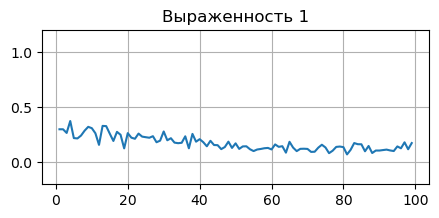

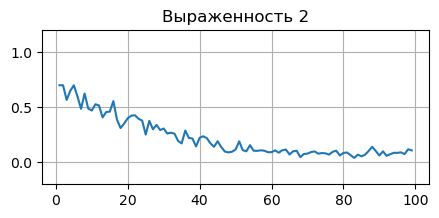

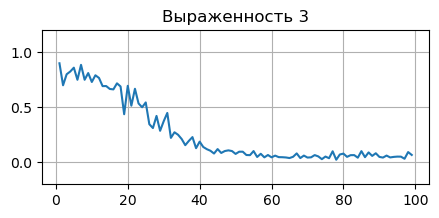

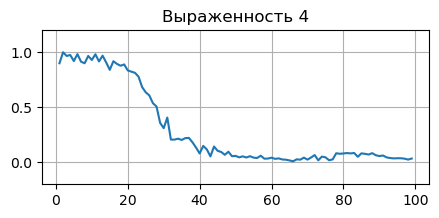

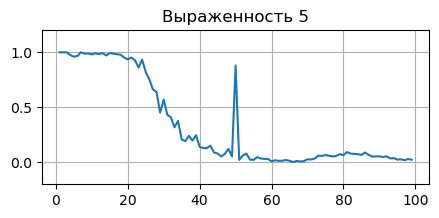

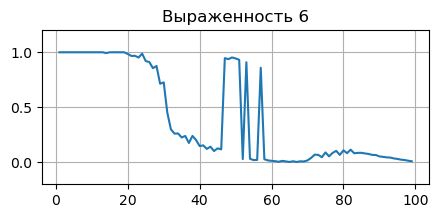

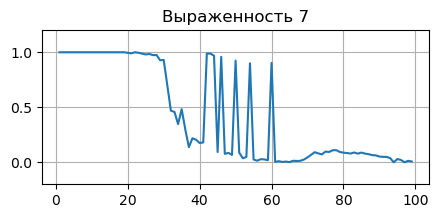

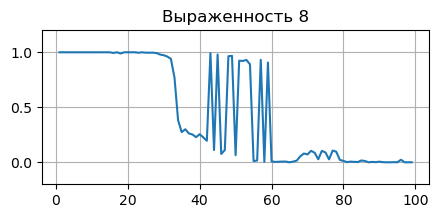

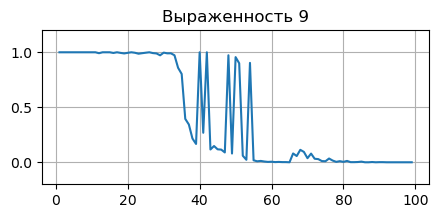

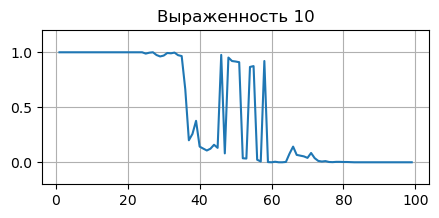

In [5]:
cols = ddd.columns
for col in cols:
    plt.figure(figsize=(5,2))
    plt.grid()
    plt.ylim([-0.2, 1.2])
    plt.plot(np.arange(1, 100), ddd[col])
    plt.title('Выраженность ' + str(col))
    plt.show()

Оказывается, что если выраженность хотя бы чытырехкратная, и при этом если реально присутствующих аномалий не больше 20%, то алгоритм нахождения аномалий по локтевой точке дает хорошие результаты.

## Остальные метрики

И по той же схеме можно на картинках помотреть остальные метрики. Выводы будут примерно такие же.